# Practical session 1: Strategies for Guessing Games

In this practical session, we will implement the strategies for guessing games studied in the tutorial.

In [3]:
# Import the modules we need

import numpy as np
import matplotlib.pyplot as plt

import json
import os
import re
import itertools

# This one is not mandatory, but shows neat progress bars, which is useful when running long simulations
from tqdm import tqdm

## Import dictionary

Below, we will import a dictionary of five-letter words in English that also contains their relative frequencies. The dictionary comes in the format of a Python dictionary, in which the keys are the words and the values are the probabilities (relative frequencies). Run the code and observe the output.

In [4]:
# Import dictionnary (with frequencies)
with open('./normalised_freq_map.json', 'r') as f:
    full_dictionary = json.load(f)
    
full_dictionary

{'aahed': 5.647135130185272e-07,
 'aalii': 3.7071500021920224e-09,
 'aargh': 4.358475115196925e-07,
 'aarti': 1.2884367135570511e-06,
 'abaca': 5.234250783717893e-07,
 'abaci': 3.723709434175814e-07,
 'aback': 3.38633107954483e-05,
 'abacs': 3.896379147679532e-09,
 'abaft': 1.4151116011238488e-06,
 'abaka': 6.523816549455655e-08,
 'abamp': 1.7851122876633865e-09,
 'aband': 2.3111999219777816e-07,
 'abase': 1.2060670880638568e-06,
 'abash': 3.2395818951054386e-07,
 'abask': 2.5371032163897447e-08,
 'abate': 1.0623407526629616e-05,
 'abaya': 1.0587935216116455e-06,
 'abbas': 1.8423948755021055e-05,
 'abbed': 2.888762801514278e-08,
 'abbes': 4.4187765376663866e-07,
 'abbey': 8.020540809310653e-05,
 'abbot': 4.446709288617227e-05,
 'abcee': 1.451965620605715e-09,
 'abeam': 1.1358899716199408e-06,
 'abear': 2.0542828437541027e-07,
 'abele': 1.170078926154355e-06,
 'abers': 2.434903896906396e-07,
 'abets': 7.240303027316777e-07,
 'abhor': 7.133966383932377e-06,
 'abide': 5.566897155209266e-0

In [37]:
# We can extract the words and probabilities from the Python dictionary into lists

words = list(full_dictionary.keys())
print(words[0:10])

probabilities = list(full_dictionary.values())
print(probabilities[0:10])

['aahed', 'aalii', 'aargh', 'aarti', 'abaca', 'abaci', 'aback', 'abacs', 'abaft', 'abaka']
[5.647135130185272e-07, 3.7071500021920224e-09, 4.358475115196925e-07, 1.2884367135570511e-06, 5.234250783717893e-07, 3.723709434175814e-07, 3.38633107954483e-05, 3.896379147679532e-09, 1.4151116011238488e-06, 6.523816549455655e-08]


1.0000000000000007

**Excercise 1:** Compute the entropy of the dictionnary: (a) supposing a uniform distribution on the words; (b) supposing the words are distributed according to their empirical frequency. Interpret the result.

In [6]:
### YOUR CODE HERE ###

# (a) compute entropy with uniform distribution
H_unif = np.log2(len(words))
print("Entropy (uniform): {} bits".format(H_unif))

# (b) compute entropy with empirical distribution
prob = np.array(probabilities)
prob = prob[prob>0]
H_emp = -np.sum(prob*np.log2(prob))
print("Entropy (empirical): {} bits".format(H_emp))

### END YOUR CODE ###

Entropy (uniform): 13.663113308455806 bits
Entropy (empirical): 9.245091962475616 bits


_(Your answer here)_ The number of bits gives the average number of yes/no questions that are needed to guess an element of the dictionnary.

## Creating a game

The following code creates a game. The methods in this class are:

* `new_game` creates a new game by choosing a secret word at random. The parameters are the number of lives (the default value is 5) and a flag that controls the display of messages. Note that the secret word is available in the variable `word`, but, of course, we cannot access this variable in our strategy.

* `try_letter` allows the player to try ask if a letter is present in the secret word and returns the pattern of the letter in the secret word. Here, the pattern is encoded as a list that contains all the positions in which the letter appears in the word. A void list means the letter is not present.

* `try_word` allows the player to guess the word. If the word is correct, the player wins; otherwise, the player loses and the game ends.

In [7]:
class HangmanGame():
    
    def __init__(self):
        with open('./normalised_freq_map.json', 'r') as f:
            self.data    = json.load(f)
            self.dict    = list(self.data.keys())
            self.probs   = list(self.data.values())
    
    def new_game(self, lives=5, displayFlag=True):
        self.lives   = lives
        self.display = displayFlag
        self.word    = np.random.choice(self.dict, p=self.probs)
        self.legnth  = len(self.word)
        return self.word

    def try_letter(self, letter):
        if self.lives > 0:
            if letter in self.word:
                return [idx for idx in range(len(self.word)) if self.word[idx]==letter]
            else:
                self.lives -= 1
                if self.lives == 0:
                    if self.display:
                        print("You lost! :(")
                    return False
                else:
                    return []
        
    def try_word(self, word):
        if self.lives > 0:
            if self.word == word:
                if self.display:
                    print("You won! :)")
                return True
            else:
                self.lives = 0
                if self.display:
                    print("You lost! :(")
                return False

Run this example to understand how the methods are used.

In [38]:
# Let's create a new game
game = HangmanGame()
game.new_game()
# The secret word is here, but we cannot access this variable in our strategy
print(game.word)
# Let's try letter 'a'. The output is the pattern of 'a' in the secret word
print(game.try_letter('a'))
# Let's see the number of remaining lives that we have
print(game.lives)
# Pretend we're feeling lucky, let's try to guess the word 'green' and see what happens...
print(game.try_word('green'))

still
[]
4
You lost! :(
False


## Playing the game

The following functions are already implemented and ready to be used. Don't spend too much time looking at what is inside them.

In [9]:
full_dictionary

{'aahed': 5.647135130185272e-07,
 'aalii': 3.7071500021920224e-09,
 'aargh': 4.358475115196925e-07,
 'aarti': 1.2884367135570511e-06,
 'abaca': 5.234250783717893e-07,
 'abaci': 3.723709434175814e-07,
 'aback': 3.38633107954483e-05,
 'abacs': 3.896379147679532e-09,
 'abaft': 1.4151116011238488e-06,
 'abaka': 6.523816549455655e-08,
 'abamp': 1.7851122876633865e-09,
 'aband': 2.3111999219777816e-07,
 'abase': 1.2060670880638568e-06,
 'abash': 3.2395818951054386e-07,
 'abask': 2.5371032163897447e-08,
 'abate': 1.0623407526629616e-05,
 'abaya': 1.0587935216116455e-06,
 'abbas': 1.8423948755021055e-05,
 'abbed': 2.888762801514278e-08,
 'abbes': 4.4187765376663866e-07,
 'abbey': 8.020540809310653e-05,
 'abbot': 4.446709288617227e-05,
 'abcee': 1.451965620605715e-09,
 'abeam': 1.1358899716199408e-06,
 'abear': 2.0542828437541027e-07,
 'abele': 1.170078926154355e-06,
 'abers': 2.434903896906396e-07,
 'abets': 7.240303027316777e-07,
 'abhor': 7.133966383932377e-06,
 'abide': 5.566897155209266e-0

In [10]:
def is_letter_in_dict(my_letter, my_dict):
    """
    Checks if a letter appears in the dictionnary.
    """
    
    # Define regular expression
    regex = '\w*' + my_letter + '\w*'
    # Filtered dictionnary
    filtered_dict = dict(filter(lambda item: re.match(regex,item[0]), my_dict.items()))
    
    return len(filtered_dict)>0


def filter_dict_by_letter(my_letter, my_dict):
    """
    Filters the dictionnary according to the appearence of a letter.
    """
    
    # Define regular expression
    regex = '\w*' + my_letter + '\w*'
    # Filtered dictionnary
    filtered_dict = dict(filter(lambda item: re.match(regex,item[0]), my_dict.items()))
    
    return filtered_dict


def filter_dict_by_pattern(my_letter, my_pattern, my_dict):
    """
    Filters the dictionnary according to a pattern for a letter.
    """
    
    # Find words length from the dictionnary
    length = len(list(my_dict)[0])
    
    # Define regular expression
    if my_pattern == []:
        regex = '^((?!' + my_letter + ').)*$' # Words in which my_letter doesn't appear
    else:
        regex = ''
        for idx in range(length):
            if idx in my_pattern:
                regex += my_letter
            else:
                regex += '[a-z]'
            
    # Filter dictionary
    filtered_dict = dict(filter(lambda item: re.match(regex,item[0]), my_dict.items()))

    return filtered_dict

<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
<>:20: SyntaxWarning: invalid escape sequence '\w'
/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_98532/3994491269.py:7: SyntaxWarning: invalid escape sequence '\w'
  regex = '\w*' + my_letter + '\w*'
/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_98532/3994491269.py:7: SyntaxWarning: invalid escape sequence '\w'
  regex = '\w*' + my_letter + '\w*'
/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_98532/3994491269.py:20: SyntaxWarning: invalid escape sequence '\w'
  regex = '\w*' + my_letter + '\w*'
/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_98532/3994491269.py:20: SyntaxWarning: invalid esc

### Random letter

Let's now implement our first strategy. It's not a very smart one, but let's see how it works:

* At each round, we randomly choose a letter from the alphabet.
* We make sure this letter still appears in the current dictionary (if it doesn't, we choose another one).
* We ask if this letter is in the secret word, receive its pattern, and update the dictionary (i.e., we remove all the words that do not fit that pattern).
* Repeat the previous steps. When there is only one word left in the dictionary, or if we run out of lives (only one life left), we try to guess the word. We choose as our guess the word in the current dictionary that has the highest probability.

Read the code as it is, run it, and observe the output. Run it multiple times to see how the output changes.

In [2]:
def compute_entropy_X(my_dict):
    
    ### YOUR CODE HERE ###

    # Normalise probabilities
    pmf = np.array(list(my_dict.values()))
    pmf /= np.sum(pmf)
    # Compute entropy
    return -np.sum(pmf[pmf>0]*np.log2(pmf[pmf>0]))
    
    ### END YOUR CODE ###

In [12]:
def play_random_letter(lives=5, displayFlag=True):

    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    # Initialise game
    game = HangmanGame()
    length = game.new_game(lives, displayFlag)
    dictionary = full_dictionary
    n_questions = 0
    H_X_array = []

    # While we still have lives
    while(game.lives>1):

        ### UNCOMMENT HERE
        H_X_array.append(compute_entropy_X(dictionary))
        ###
        
        # If more than one word in the current dictionary
        if len(dictionary)>1:

            # Choose a letter randomly
            letter = np.random.choice(alphabet)
            alphabet.remove(letter)

            # Check if that letter is used in the current dictionary
            if is_letter_in_dict(letter,dictionary):

                # Try the letter
                pattern = game.try_letter(letter)
                if displayFlag:
                    print(letter,pattern)
                n_questions += 1

                # Filter the words from the dictionary that follow the pattern
                dictionary = filter_dict_by_pattern(letter,pattern,dictionary)

        # If only one word remains in the dictionary, exit the loop
        else:
            break

    # When you have only one more life, guess a word
    if displayFlag:
        print("Current dictionary:")
        print(dictionary)
    # Choose the most probable word
    guess = max(dictionary, key=dictionary.get)

    if displayFlag:
        print("Guess: " + guess)
    result = game.try_word(guess)
    if displayFlag:
        print("Correct word: " + game.word)
    
    # Output the result (True or False), the number of reamaning lives, the number of questions asked,
    # and the array of entropies
    return result, game.lives, n_questions, H_X_array

In [13]:
# Play the game with 10 lives
result,remaining_lives,n_questions,H_X_array = play_random_letter(10)
print("Output: {}".format([result,remaining_lives,n_questions]))

i []
b []
z []
l [0]
h []
f []
k []
w []
y []
x []
Current dictionary:
{'laced': 3.781858130487382e-05, 'lacer': 1.2438491884382696e-07, 'laces': 1.2685212366912116e-05, 'lacet': 4.7121093122253306e-08, 'laded': 3.1532269663148115e-07, 'laden': 8.33773672896018e-05, 'lader': 1.4969350162620624e-06, 'lades': 2.739181703305173e-07, 'ladle': 1.0265385080125502e-05, 'laers': 9.041143764558951e-09, 'laevo': 9.657099436249383e-08, 'lagan': 9.406442325116547e-07, 'lager': 1.0243998322817953e-05, 'lalls': 3.6837861490658e-08, 'lamas': 4.480711322290612e-06, 'lamed': 2.0148262335454498e-06, 'lamer': 8.520261813499097e-07, 'lames': 5.50916997171183e-07, 'lamps': 7.806088638106014e-05, 'lanas': 1.6428160850247275e-07, 'lance': 7.258982568395465e-05, 'lande': 9.340786686305658e-06, 'lands': 0.0002936170448079995, 'lanes': 4.4368463905674874e-05, 'lants': 2.3534540725897568e-07, 'lapel': 7.378975725156802e-06, 'lapje': 2.8903213953246305e-09, 'lapse': 3.645355721839173e-05, 'lards': 9.5309190735377

**Exercise 2:** Now go back and modify the code so that at each round $t$ you compute the entropy $H(X|Y_t)$, and save them in the variable `H_X_array`. Don't forget to normalise the probabilities of the updated dictionary. Plot the evolution of this quantity below.

In [1]:
t_vec = np.arange(len(H_X_array))

plt.figure()
plt.plot(t_vec,H_X_array, '--o')
plt.xlim(0,len(t_vec)-1)
plt.ylim(0)
plt.xlabel('Round $t$')
plt.ylabel('Entropy $H(X|Y_t=y_t)$ [bits]')
plt.grid()
plt.show()

NameError: name 'np' is not defined

**Exercise 2 (bis):** If you run the simulation many times, you should see at some point a plot that is not monotonically decreasing (i.e., at some round the entropy increases). A less attentive student could protest and say that this is not possible, since, as the mantra goes, _conditioning reduces entropy_. The simulation results are correct, though. What is wrong with this reasoning then? Hint: look carefully at the plot.

_(Your answer here)_ Conditioning reduces entropy, on average: $H(X|Y) = \mathbb{E}_{y}[H(X|Y=y)] \le H(X)$. What we compute and plot is one realisation $H(X|Y=y)$, though.

### Fixed most frequent letter

We can certainly do better than that. Instead of asking a random letter, let's ask the letters in the order of the [most frequent words in English](https://en.wikipedia.org/wiki/Letter_frequency#Relative_frequencies_of_the_first_letters_of_a_word_in_English_language).

Again, run multiple times and observe the output.

In [15]:
def play_fixed_frequent_letter(lives=5, displayFlag=True):

    ordered_alphabet = ['e', 't', 'a', 'o', 'i', 'n', 's', 'h', 'r', 'd', 'l', 'c', 'u',
                        'm', 'w', 'f', 'g', 'y', 'p', 'b', 'v', 'k', 'j', 'x', 'q', 'z']

    # Initialise game
    length = game.new_game(lives,displayFlag)
    dictionary = full_dictionary
    n_questions = 0
    H_X_array = []

    # While we still have lives
    while(game.lives>1):
        
        ### UNCOMMENT HERE
        H_X_array.append(compute_entropy_X(dictionary))
        ###

        # If more than one word in the current dictionary
        if len(dictionary)>1:

            # Choose a letter according to the ordered sequence
            letter = ordered_alphabet[0]
            ordered_alphabet.remove(letter)

            # Check if that letter is used in the current dictionary
            if is_letter_in_dict(letter,dictionary):

                # Try the letter
                pattern = game.try_letter(letter)
                if displayFlag:
                    print(letter,pattern)
                n_questions += 1

                # Filter the words from the dictionnary that follow the pattern
                dictionary = filter_dict_by_pattern(letter,pattern,dictionary)

        # If only one word remains in the dictionnary, exit the loop
        else:
            break

    # Guess a word
    if displayFlag:
        print("Current dictionary:")
        print(dictionary)
    # Choose the most probable word
    guess = max(dictionary, key=dictionary.get)

    if displayFlag:
        print("Guess: " + guess)
    result = game.try_word(guess)
    if displayFlag:
        print("Correct word: " + game.word)
    
    # Output the result (True or False), the number of reamaning lives, the number of questions asked,
    # and the array of entropies
    return result, game.lives, n_questions, H_X_array

In [16]:
# Play the game with 10 lives
result,remaining_lives,n_questions,H_X_array = play_fixed_frequent_letter(10)
print("Output: {}".format([result,remaining_lives,n_questions]))

e []
t [4]
a []
o []
i [2]
n [3]
s []
r [1]
Current dictionary:
{'print': 0.00038174032021410755}
Guess: print
You won! :)
Correct word: print
Output: [True, 6, 8]


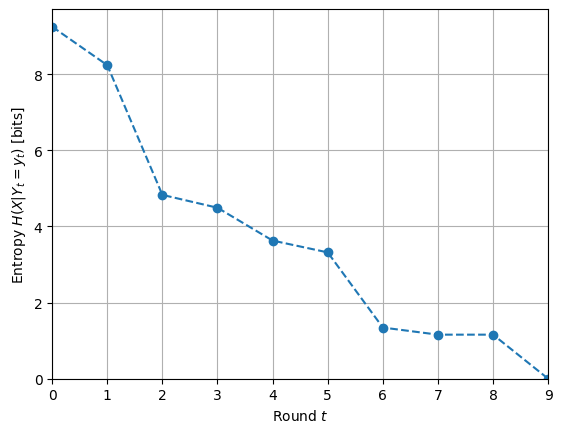

In [17]:
t_vec = np.arange(len(H_X_array))

plt.figure()
plt.plot(t_vec,H_X_array, '--o')
plt.xlim(0,len(t_vec)-1)
plt.ylim(0)
plt.xlabel('Round $t$')
plt.ylabel('Entropy $H(X|Y_t=y_t)$ [bits]')
plt.grid()
plt.show()

## Information-theoretic strategy

Now, let's begin implementing our strategy based on information theory.

**Exercise 3:** As a first step, write a function that, for each letter, computes the entropy of the corresponding pattern. Fill in the code below.

In [5]:
def generate_all_patterns(length):
    """
    Generate all patterns for a word of length k.
    """
    
    patterns = []
    
    for i in range(length+1):
        patterns.extend([list(x) for x in itertools.combinations(range(length), i)])
        
    return patterns

def compute_letter_entropies(my_dict, my_alphabet):
    """
    Compute the entropy of the pattern associated to each letter, given a dictionary and an alphabet.
    """

    letter_entropies = []
    
    ### YOUR CODE HERE ###
    
    # Find words length from the dictionnary
    length = len(list(my_dict)[0])
    all_patterns = generate_all_patterns(length)
    
    # For each letter
    for my_letter in my_alphabet:

        # Compute the patterns distribution
        pattern_probs = []
        words_seen=[]
        # For each pattern
        for my_pattern in all_patterns:
            p_pattern = 0

            # Filter the words that fit the pattern
            pattern_dict = filter_dict_by_pattern(my_letter, my_pattern, my_dict)
            if pattern_dict!={}:
                for word in pattern_dict.copy().keys():
                        if word in words_seen:
                            del pattern_dict[word]
                words_seen+=pattern_dict.keys()
            for item in pattern_dict.items():
                word, p_word = item
                p_pattern += p_word

            pattern_probs.append(p_pattern)


        # Normalise probabilities
        pattern_probs /= np.sum(pattern_probs)
        
        # Compute the entropy of that distribution
        pmf = np.array(pattern_probs)
        H_letter = -np.sum(pmf[pmf>0]*np.log2(pmf[pmf>0]))
        letter_entropies.append(H_letter)
        
    ### END YOUR CODE ###
        
    return letter_entropies

Run the code below to evaluate the entropy of each letter in the original dictionary.

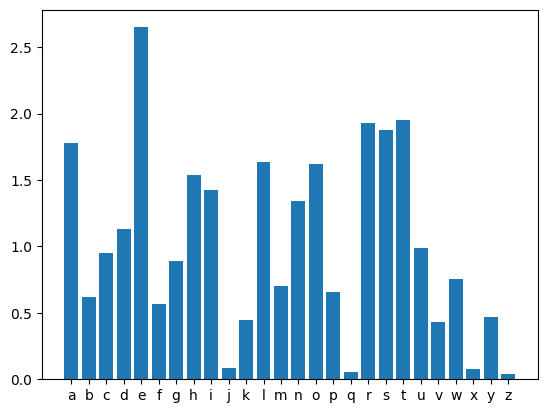

In [19]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

H_letters = compute_letter_entropies(full_dictionary,alphabet)

plt.bar(alphabet,H_letters)
plt.show()

**Exercise 4:** Print the letters in the alphabet, by decreasing pattern entropy (the ordering $\phi$ from the tutorial). Which letter has the pattern with highest entropy? Hint: you can use the functions `np.argsort` and `np.flip`.

In [20]:
### YOUR CODE HERE ###

# Order letters by decreasing pattern entropy
idx = np.argsort(H_letters)
ordered_alphabet_phi = np.flip(np.array(alphabet)[idx])
ordered_entropy_pattern = np.flip(np.array(H_letters)[idx])
print(ordered_alphabet_phi)
print(ordered_entropy_pattern)

### END YOUR CODE ###

['e' 't' 'r' 's' 'a' 'l' 'o' 'h' 'i' 'n' 'd' 'u' 'c' 'g' 'w' 'm' 'p' 'b'
 'f' 'y' 'k' 'v' 'j' 'x' 'q' 'z']
[2.64916515 1.95476318 1.92907846 1.87824535 1.77948301 1.63350358
 1.62374219 1.54108492 1.42447717 1.34027482 1.13208073 0.98548447
 0.95083906 0.88951677 0.75732928 0.70037475 0.65918041 0.6193237
 0.56320565 0.46952095 0.44463143 0.43146609 0.08481328 0.07365759
 0.05801667 0.04095756]


**Exercise 5:** In the best case, compute a lower bound on the number of questions needed to guess the word correctly. Hint: look at Question 6 from the tutorial again, you can use `np.cumsum`.

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/var/folders/yk/3f16fbd17g7cmxqc9gfqwh9h0000gp/T/ipykernel_98532/2080776979.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(H_cumsum, '--o', label='Cumulative $H(f(X,\phi(i)))$')


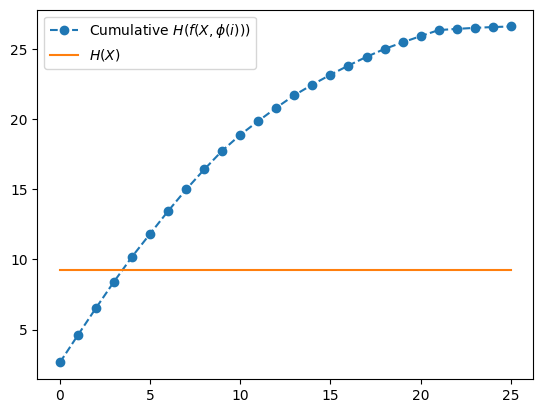

In [21]:
### YOUR CODE HERE ###

H_cumsum = np.cumsum(ordered_entropy_pattern)

plt.figure()
plt.plot(H_cumsum, '--o', label='Cumulative $H(f(X,\phi(i)))$')
plt.plot(H_emp*np.ones(len(H_cumsum)), label='$H(X)$')
plt.legend()
plt.show()

### END YOUR CODE ###

**Exercise 6:** Complete the code below to implement a strategy that chooses the letter associated to the highest entropy pattern, as discussed in the tutorial. Since the first letter will be always the same (as computed above), this can be hard coded in your implementation to save some computational time.

In [22]:
def play_maximise_entropy(lives,displayFlag=True):

    full_alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                     'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    alphabet = full_alphabet
    
    # Initialise game
    length = game.new_game(lives,displayFlag)
    dictionary = full_dictionary
    n_questions = 0
    H_X_array = []

    # While we still have lives
    while(game.lives>1):
        
        ### YOUR CODE HERE ###
        
        H_X_array.append(compute_entropy_X(dictionary))
        
        # If more than one word in the current dictionnary
        if len(dictionary)>1:

            if len(alphabet)==26:
                # First guess
                letter = 'e'
            else:
                # Compute the entropies of each letter's pattern
                letter_entropies = compute_letter_entropies(dictionary,alphabet)
                #print(letter_entropies)
                letter = alphabet[np.argmax(letter_entropies)]
            
            alphabet.remove(letter)

            # Check if that letter is used in the current dictionnary
            if is_letter_in_dict(letter,dictionary):

                # Try the letter
                pattern = game.try_letter(letter)
                if displayFlag:
                    print(letter,pattern)
                n_questions += 1

                # Filter the words from the dictionnary that follow the pattern
                dictionary = filter_dict_by_pattern(letter,pattern,dictionary)

        # If only one word remains in the dictionnary, exit the loop
        else:
            break
            
        ### END YOUR CODE ###

    # When you have only one more life, guess a word
    if displayFlag:
        print("Current dictionary:")
        print(dictionary)
    # Choose the most probable word
    guess = max(dictionary, key=dictionary.get)

    if displayFlag:
        print("Guess: " + guess)
    result = game.try_word(guess)
    if displayFlag:
        print("Correct word: " + game.word)
    
    # Output the result (True or False), the number of reamaning lives, the number of questions asked,
    # and the array of entropies
    return result, game.lives, n_questions, H_X_array

In [23]:
# Play the game with 10 lives
result,remaining_lives,n_questions,H_X_array = play_maximise_entropy(10)
print("Output: {}".format([result,remaining_lives,n_questions]))

e []
o [1]
l [3]
w []
s []
d [4]
c [0]
Current dictionary:
{'could': 0.01601866616932688}
Guess: could
You won! :)
Correct word: could
Output: [True, 7, 7]


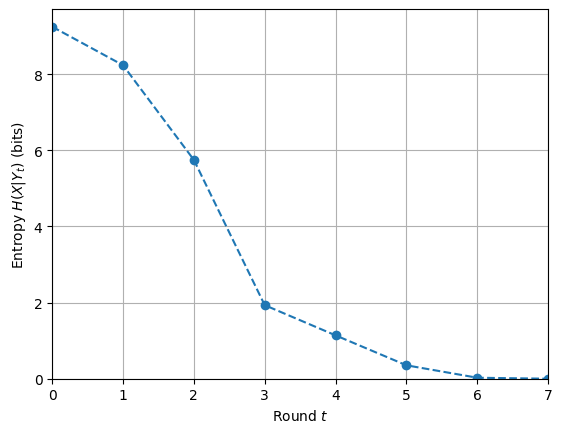

In [24]:
t_vec = np.arange(len(H_X_array))

plt.figure()
plt.plot(t_vec,H_X_array, '--o')
plt.xlim(0,len(t_vec)-1)
plt.ylim(0)
plt.xlabel('Round $t$')
plt.ylabel('Entropy $H(X|Y_t)$ (bits)')
plt.grid()
plt.show()

## Dynamic most frequent letter strategy (optional)

Another strategy mentioned during the tutorial is to choose the most frequent letter in the current dictionary, at each round.

**Exercise 7 (optional):** As a first step, write a function that computes the frequency of each letter in the current dictionary. Fill in the code below. Hint: you can use `filter_dict_by_letter`.

In [25]:
def compute_letter_frequencies(my_dict, my_alphabet):

    letter_frequencies = []
    
    ### YOUR CODE HERE ###
    
    # For each letter
    for my_letter in my_alphabet:

        filtered_dict = filter_dict_by_letter(my_letter,my_dict)
        letter_frequencies.append(len(filtered_dict))
        
    ### END YOUR CODE ###
        
    return letter_frequencies

Run the code below to evaluate the entropy of each letter in the original dictionary.

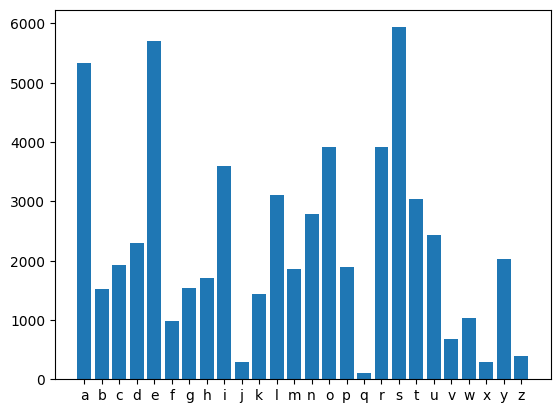

In [26]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

n_letters = compute_letter_frequencies(full_dictionary, alphabet)
    
plt.bar(alphabet,n_letters)
plt.show()

**Exercise 8 (optional):** Print the letters in the alphabet, by decreasing frequency. Which letter is the most frequent? Compare with the fixed order from the second strategy. Hint: you can use the functions `np.argsort` and `np.flip`.

In [27]:
### YOUR CODE HERE ###

# Order letters by decreasing pattern entropy
idx = np.argsort(n_letters)
ordered_alphabet_freq = np.flip(np.array(alphabet)[idx])
ordered_freq = np.flip(np.array(n_letters)[idx])
print(ordered_alphabet_freq)
print(ordered_freq)

### END YOUR CODE ###

['s' 'e' 'a' 'o' 'r' 'i' 'l' 't' 'n' 'u' 'd' 'y' 'c' 'p' 'm' 'h' 'g' 'b'
 'k' 'w' 'f' 'v' 'z' 'j' 'x' 'q']
[5936 5705 5330 3911 3909 3589 3114 3033 2787 2436 2298 2031 1920 1885
 1868 1708 1543 1519 1444 1028  990  674  391  289  287  111]


**Exercise 9 (optional):** Complete the code below to implement a strategy that chooses the most frequent letter. Since the first letter will be always the same (as computed above), this can be hard coded in your implementation to save some computational time.

In [28]:
def play_dynamic_frequent_letter(lives=5, displayFlag=True):

    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

    # Initialise game
    length = game.new_game(lives,displayFlag)
    dictionary = full_dictionary
    n_questions = 1
    H_X_array = []

    # While we still have lives
    while(game.lives>1):
        
        ### YOUR CODE HERE ###
        
        H_X_array.append(compute_entropy_X(dictionary))
        
        # If more than one word in the current dictionnary
        if len(dictionary)>1:
            
            if len(alphabet)==26:
                # First guess
                letter = 's'
            else:
                # Choose a letter according to the frequency sequence
                n_letters = compute_letter_frequencies(dictionary, alphabet)
                letter = alphabet[np.argmax(n_letters)]
            
            alphabet.remove(letter)

            # Check if that letter is used in the current dictionnary
            if is_letter_in_dict(letter,dictionary):

                # Try the letter
                pattern = game.try_letter(letter)
                if displayFlag:
                    print(letter,pattern)
                n_questions += 1

                # Filter the words from the dictionnary that follow the pattern
                dictionary = filter_dict_by_pattern(letter,pattern,dictionary)
                
        # If only one word remains in the dictionnary, exit the loop
        else:
            break
            
        ### END YOUR CODE ###


    # Guess a word
    if displayFlag:
        print("Current dictionnary:")
        print(dictionary)
    # Choose the most probable word
    guess = max(dictionary, key=dictionary.get)

    if displayFlag:
        print("Guess: " + guess)
    result = game.try_word(guess)
    if displayFlag:
        print("Correct word: " + game.word)
    
    # Output the result (True or False), the number of reamaning lives, the number of questions asked,
    # and the array of entropies
    return result, game.lives, n_questions, H_X_array

In [33]:
# Play the game with 10 lives
result,remaining_lives,n_questions,H_X_array = play_dynamic_frequent_letter(10)
print("Output: {}".format([result,remaining_lives,n_questions]))

s [3]
e []
a []
o []
i [1]
y []
t [4]
d []
f [0]
Current dictionnary:
{'first': 0.011068043329423493}
Guess: first
You won! :)
Correct word: first
Output: [True, 5, 10]


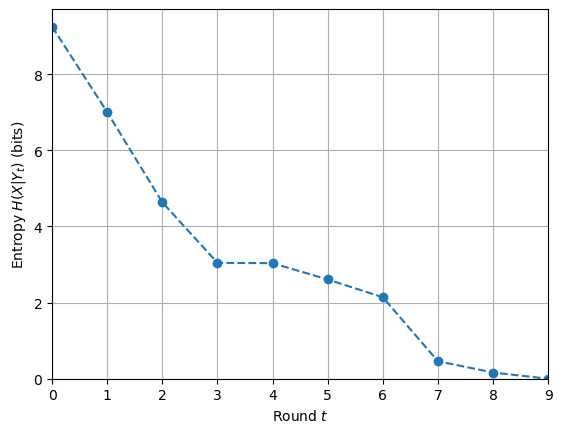

In [27]:
t_vec = np.arange(len(H_X_array))

plt.figure()
plt.plot(t_vec,H_X_array, '--o')
plt.xlim(0,len(t_vec)-1)
plt.ylim(0)
plt.xlabel('Round $t$')
plt.ylabel('Entropy $H(X|Y_t)$ (bits)')
plt.grid()
plt.show()

## Comparison between different strategies

We are now going to do a more systematic comparison between the different strategies.

### 1. The hangmang game

In this game, the number of lives is fixed (say 5), and we evaluate the average success rate (rate of wins).

**Exercise 10:** Run each of the strategies many times (say, at least 100), compute the average success rate and plot the histograms of the remaining lives, for each strategy.

In [28]:
# Simulation parameters
n_runs = 100  # Increase if you can
n_lives = 5

In [29]:
### Random letter (RL)

n_wins_rl = 0
n_lives_rl = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):
    
    result,lives,_,_ = play_random_letter(n_lives,False)
    n_lives_rl.append(lives)
    if result:
        n_wins_rl += 1
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.06it/s]


In [30]:
### Fixed letter frequencies (FF)

n_wins_ff = 0
n_lives_ff = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):

    result,lives,_,_ = play_fixed_frequent_letter(n_lives,False)
    n_lives_ff.append(lives)
    if result:
        n_wins_ff += 1
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.00it/s]


In [31]:
### Maximum entropy (ME)

n_wins_me = 0
n_lives_me = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):

    result,lives,_,_ = play_maximise_entropy(n_lives,False)
    n_lives_me.append(lives)
    if result:
        n_wins_me += 1
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


In [32]:
### Dinamyc letter frequencies (DF) -- optional

n_wins_df = 0
n_lives_df = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):

    result,lives,_,_ = play_dynamic_frequent_letter(n_lives,False)
    n_lives_df.append(lives)
    if result:
        n_wins_df += 1
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 11.18it/s]


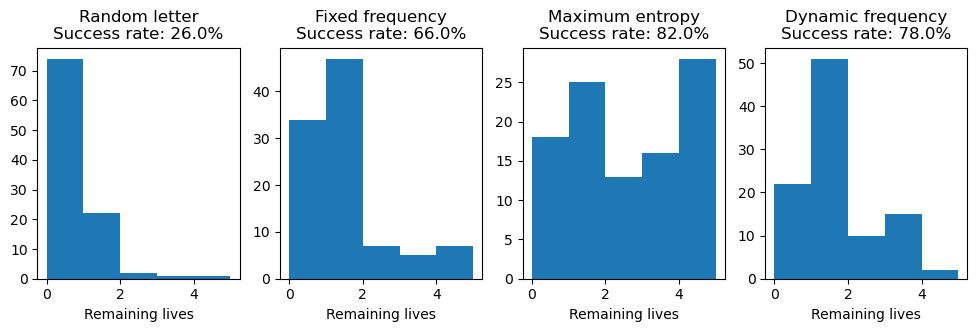

In [33]:
plt.figure(figsize=(12,3))

### COMPLETE THE CODE

plt.subplot(1,4,1)
plt.hist(n_lives_rl,range=(0,n_lives),bins=n_lives)
plt.title("Random letter\nSuccess rate: {}%".format(100*n_wins_rl/n_runs))
plt.xlabel("Remaining lives")

plt.subplot(1,4,2)
plt.hist(n_lives_ff,range=(0,n_lives),bins=n_lives)
plt.title("Fixed frequency\nSuccess rate: {}%".format(100*n_wins_ff/n_runs))
plt.xlabel("Remaining lives")

plt.subplot(1,4,3)
plt.hist(n_lives_me,range=(0,n_lives),bins=n_lives)
plt.title("Maximum entropy\nSuccess rate: {}%".format(100*n_wins_me/n_runs))
plt.xlabel("Remaining lives")

plt.subplot(1,4,4)
plt.hist(n_lives_df,range=(0,n_lives),bins=n_lives)
plt.title("Dynamic frequency\nSuccess rate: {}%".format(100*n_wins_df/n_runs))
plt.xlabel("Remaining lives")

plt.show()

### 2. The wheel of the fortune

In this game, the number of lives is unlimited (so we set as 26), and we evaluate the number of questions we need to find the correct word.

**Exercise 11:** Run each of the strategies many times (say, at least 100), compute the average number of questions required, and plot the histograms of the number of questions, for each strategy.

In [34]:
# Simulation parameters
n_runs = 100  # Increase if you can
n_lives = 26

In [35]:
### Random letter

n_questions_rl = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):

    result,_,questions,_ = play_random_letter(n_lives,False)
    n_questions_rl.append(questions)
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 23.54it/s]


In [36]:
### Fixed letter frequencies (FF)

n_questions_ff = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):

    result,_,questions,_ = play_fixed_frequent_letter(n_lives,False)
    n_questions_ff.append(questions)
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 51.73it/s]


In [37]:
### Maximum entropy (ME)

n_questions_me = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):

    result,_,questions,_ = play_maximise_entropy(n_lives,False)
    n_questions_me.append(questions)
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]


In [38]:
### Dinamyc letter frequencies (DF) -- optional

n_questions_df = []

### YOUR CODE HERE ###

for i in tqdm(range(n_runs)):

    result,_,questions,_ = play_dynamic_frequent_letter(n_lives,False)
    n_questions_df.append(questions)
        
### END YOUR CODE ###

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.99it/s]


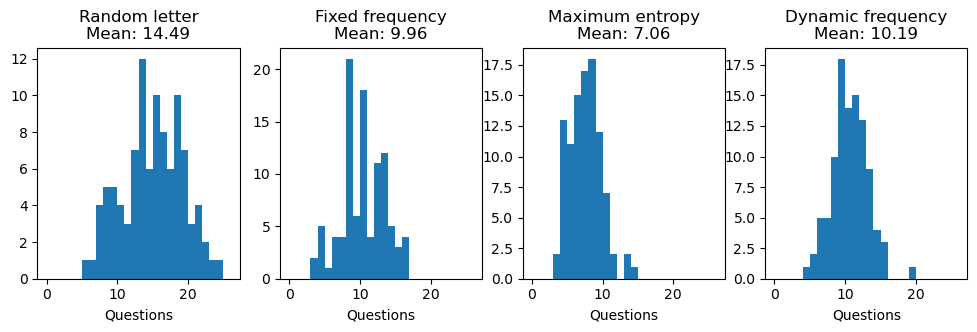

In [39]:
plt.figure(figsize=(12,3))

### COMPLETE THE CODE

plt.subplot(1,4,1)
plt.hist(n_questions_rl,range=(0,26),bins=26)
plt.title("Random letter\nMean: {}".format(np.mean(n_questions_rl)))
plt.xlabel("Questions")

plt.subplot(1,4,2)
plt.hist(n_questions_ff,range=(0,26),bins=26)
plt.title("Fixed frequency\nMean: {}".format(np.mean(n_questions_ff)))
plt.xlabel("Questions")

plt.subplot(1,4,3)
plt.hist(n_questions_me,range=(0,26),bins=26)
plt.title("Maximum entropy\nMean: {}".format(np.mean(n_questions_me)))
plt.xlabel("Questions")

plt.subplot(1,4,4)
plt.hist(n_questions_df,range=(0,26),bins=26)
plt.title("Dynamic frequency\nMean: {}".format(np.mean(n_questions_df)))
plt.xlabel("Questions")

plt.show()

## Postlude

Is it possible to use a similar strategy to play [Wordle](https://www.nytimes.com/games/wordle/index.html)? Discover [here](https://www.youtube.com/watch?v=v68zYyaEmEA).

This practical session was inspired by [3b1b](https://github.com/3b1b/) and [tiagoft](https://github.com/tiagoft).